# Text2bank explorácia

- výkonnosť modelu cez kľúčové slová

In [1]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from nb_query_eval import Ensemble, QueryEvaluator, Tokenizer
from nb_query_eval.helpers import read_keyword_matrix

[nltk_data] Downloading package punkt to /home/sfabo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
t2b = pd.read_csv(os.getcwd() + '/data_text2bank/clean-pairs-enhanced-sort.csv')
labels = t2b['kategorie'].unique()

In [13]:
print(t2b.groupby('kategorie').count().sort_values('text_cz', ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  text\_cz \\
kategorie                               &          \\
\midrule
jednorázová platba tuzemská             &       88 \\
výpisy                                  &       69 \\
chci půjčit/kolik mi půjčíte            &       59 \\
sjednat schůzku na pobočce              &       41 \\
trvalé platby                           &       37 \\
ztratil jsem platební kartu             &       33 \\
potřebuji mimořádnou splátku (hypotéky) &       25 \\
svolení k inkasu a sipo                 &       24 \\
čekající platby                         &       24 \\
sjednat hypotéku                        &       23 \\
splátka kreditní karty                  &       23 \\
limity                                  &       22 \\
potřebuji potvrzení o platbě            &       22 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1520/551537986.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(t2b.groupby('kategorie').count().sort_values('text_cz', ascending=False).to_latex())


## Ako sa správa klasifikácia intentov len na základe kľúčových slov?

- pozrime sa na celý dataset t2b, aký má výkon 

In [4]:
evaluators = [QueryEvaluator(keyword_matrix=read_keyword_matrix('nb_query_eval/resources/kw_matrix04.csv'), n_best_candidates=2, largest_mistake=1)]

with open('nb_query_eval/resources/stopwords.txt', 'r') as f:
    tokenizer = Tokenizer(f.readlines())

ens = Ensemble(action_names=labels, evaluators=evaluators, tokenizer=tokenizer, )

def batch_eval(text, ensamble):
    ensamble.fit(text)
    y_pred = ensamble.evaluate(sort_output=False)
    y_pred = [t[0] for t in y_pred]
    return y_pred

Priemerný počet slov na vetu

In [13]:
tokenizer = Tokenizer([])
np.mean([len(tks) for tks in t2b['text_cz'].apply(tokenizer.fit).tolist()])

5.151020408163265

In [9]:
y_pred = t2b['text_cz'].apply(batch_eval, args=(ens,))

In [10]:
y_true = t2b['kategorie'].apply(lambda x: labels.tolist().index(x))

In [11]:
from sklearn.metrics import f1_score, top_k_accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def metrics_complex(logits, y_true, labels=list(range(90))):
    y_pred = logits
    # y_true_wgts = np.unique(y_true, return_counts=True)[1]
    # y_true_wgts = [y_true_wgts[y] for y in y_true]

    f1 = f1_score(y_true, np.argmax(y_pred, axis=1), labels=labels, average='weighted')

    acc_bal = balanced_accuracy_score(y_true, np.argmax(y_pred, axis=1))
    acc = top_k_accuracy_score(y_true, y_pred, k=1, labels=labels)
    acc_top3 = top_k_accuracy_score(y_true, y_pred, k=3, labels=labels)

    y_test_b = label_binarize(y=y_true, classes=np.array(labels))
    try:
        roc_auc = roc_auc_score(y_test_b, y_pred, multi_class='ovr')
    except:
        roc_auc = np.nan

    return {"f1": f1, "acc_bal": acc_bal, "acc": acc, "acc_top_3": acc_top3, "roc_auc": roc_auc}

In [12]:

y_pred = np.array([np.array(y) for y in y_pred])

In [13]:
metrics_complex(y_pred, y_true, labels=range(13))
# f1_score(y_true, np.argmax(y_pred, axis=1), labels=labels, average='weighted')

{'f1': 0.7936317969389797,
 'acc_bal': 0.7710110421025819,
 'acc': 0.7306122448979592,
 'acc_top_3': 0.8816326530612245,
 'roc_auc': 0.9626367808784753}

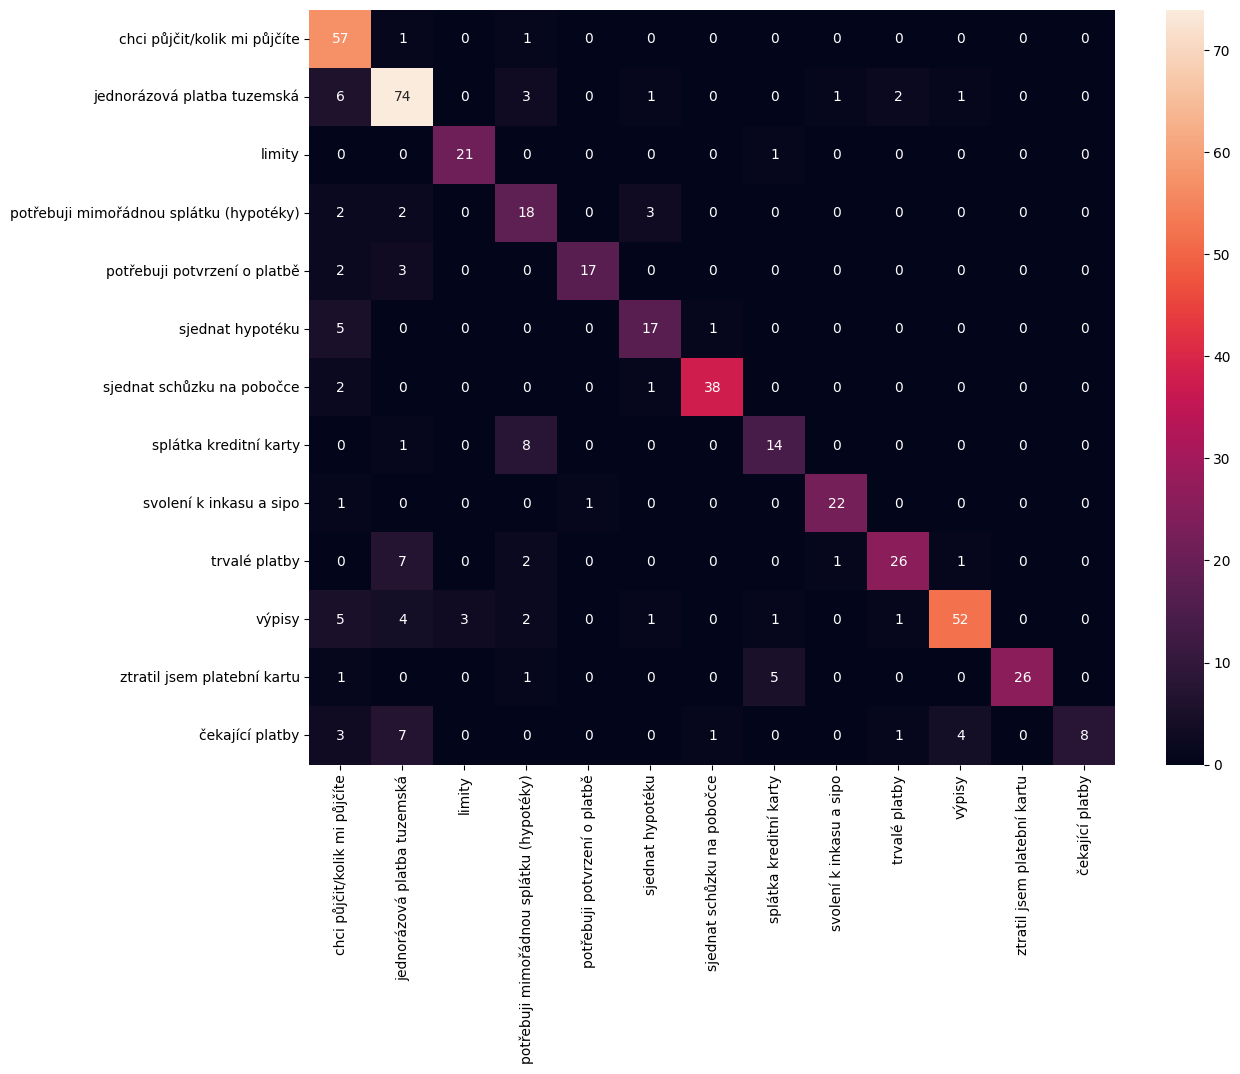

In [14]:
from sklearn.metrics import confusion_matrix

c_mat = confusion_matrix(y_true.tolist(), np.argmax(y_pred, axis=1))
plt.figure(figsize=(13,10), dpi=100)
sns.heatmap(c_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=labels))
# labels

                                         precision    recall  f1-score   support

           chci půjčit/kolik mi půjčíte       0.68      0.97      0.80        59
            jednorázová platba tuzemská       0.75      0.84      0.79        88
                                 limity       0.88      0.95      0.91        22
potřebuji mimořádnou splátku (hypotéky)       0.51      0.72      0.60        25
           potřebuji potvrzení o platbě       0.94      0.77      0.85        22
                       sjednat hypotéku       0.74      0.74      0.74        23
             sjednat schůzku na pobočce       0.95      0.93      0.94        41
                 splátka kreditní karty       0.67      0.61      0.64        23
                svolení k inkasu a sipo       0.92      0.92      0.92        24
                          trvalé platby       0.87      0.70      0.78        37
                                 výpisy       0.90      0.75      0.82        69
            ztratil jsem pl

### Pozorovanie 

- dáta neboli rozdelené, výsledky sú z celého t2b datasetu.
- klasifikácia prebieha štýlom: 
  - -> z vety detekuj len slová 
  - -> odstráň stop slová 
  - -> pozri na levenstein podobnosť spomedzi všetkých kľúčových slov, vyber najpodobnejšie 
  - -> z NaiveBayes matice kľúčových slov zrátaj najlepšiu zhodu 
  - -> vráť pravdepodobnostnú distribúciu triedy.

### Záver

- presnosť je podobná (a trochu lepšia) ako BERT - FERNET aj spolu s 


## Pozrime sa, aké vstupy boli klasifikované zle na výpisoch

In [82]:
def batch_eval_full(text, ensamble, sort=False):
    ensamble.fit(text)
    y_pred = ensamble.evaluate(sort_output=sort)
    # y_pred = [t[0] for t in y_pred]
    return y_pred

res = t2b[t2b['kategorie'] == 'potřebuji mimořádnou splátku (hypotéky)']['text_cz'].apply(lambda x: batch_eval_full(x, ens, True)).reset_index(drop=True)
res_lab = t2b[t2b['kategorie'] == 'potřebuji mimořádnou splátku (hypotéky)']['text_cz'].apply(lambda x: np.argmax(batch_eval(x, ens))).reset_index(drop=True)
b_df = t2b[t2b['kategorie'] == 'potřebuji mimořádnou splátku (hypotéky)'].reset_index(drop=True)


b_df['res'] = res
b_df['res_lab'] = res_lab


b_df[b_df['res_lab'] != 3]

text_cz  \
3                           Dej přebytek na hypotéku.   
5   Dobrý den, chci se zeptat která banka umožňuje...   
8   Mohu zaplatit výjimečně vyšší částku než mám s...   
9   Mám hypo 1.116.000 cca od začátku září tohoto ...   
10           Mám peníze navíc, co s nimi můžu udělat?   
15                       Zaplať 250´000,- na hypotéku   
24                                 splátkový kalendář   

                                  kategorie  \
3   potřebuji mimořádnou splátku (hypotéky)   
5   potřebuji mimořádnou splátku (hypotéky)   
8   potřebuji mimořádnou splátku (hypotéky)   
9   potřebuji mimořádnou splátku (hypotéky)   
10  potřebuji mimořádnou splátku (hypotéky)   
15  potřebuji mimořádnou splátku (hypotéky)   
24  potřebuji mimořádnou splátku (hypotéky)   

                                                  res  res_lab  
3   [(0.27302275189599134, 5, sjednat hypotéku), (...        5  
5   [(0.14685314685314685, 1, jednorázová platba t...        1  
8   [(0.11538461538461536, 1, jednorázová platba t...        1  
9   [(0.2792983693088977, 5, sjednat hypotéku), (0...        5  
10  [(0.13461538461538458, 0, chci půjčit/kolik mi...        0  
15  [(0.2363977485928705, 5, sjednat hypotéku), (0...        5  
24  [(0.07692307692307691, 0, chci půjčit/kolik mi...        0

In [69]:
def batch_eval_full(text, ensamble, sort=False):
    ensamble.fit(text)
    y_pred = ensamble.evaluate(sort_output=sort)
    # y_pred = [t[0] for t in y_pred]
    return y_pred

res = t2b[t2b['kategorie'] == 'čekající platby']['text_cz'].apply(lambda x: batch_eval_full(x, ens, True)).reset_index(drop=True)
res_lab = t2b[t2b['kategorie'] == 'čekající platby']['text_cz'].apply(lambda x: np.argmax(batch_eval(x, ens))).reset_index(drop=True)
b_df = t2b[t2b['kategorie'] == 'čekající platby'].reset_index(drop=True)

b_df['res'] = res
b_df['res_lab'] = res_lab

b_df[b_df['res_lab'] != 12]
# b_df

text_cz        kategorie  \
0                Chci vidět seznam čekajících plateb.  čekající platby   
1                    Jaké platby mám zadané k úhradě?  čekající platby   
2                       Které platby jsou na čekačce?  čekající platby   
3                                Ty ryby už připluly?  čekající platby   
4                            Všechny platby proběhly?  čekající platby   
5                              Za co jsem dnes platil  čekající platby   
11                    jaké platby se ještě neprovedli  čekající platby   
12   kolik mám do konce měsíce naplánovaných výdavků?  čekající platby   
13  kolik plateb a v jaké sumě mě ještě čeká do ko...  čekající platby   
14  kolik plateb ještě zbývá a které jsou na čekačce?  čekající platby   
15                mám nějakou nezrealizovanou platbu?  čekající platby   
16                     mám nějaké naplánované platby?  čekající platby   
17                                nezaúčtované platby  čekající platby   
19                                          rezervace  čekající platby   
21                         výpis neprovedených plateb  čekající platby   
23          zobrazit všechny ještě neprovedené platby  čekající platby   

                                                  res  res_lab  
0   [(0.1906115338773265, 9, trvalé platby), (0.19...        9  
1   [(0.18729096989966554, 1, jednorázová platba t...        1  
2   [(0.10769230769230771, 1, jednorázová platba t...        1  
3   [(0.07692307692307691, 0, chci půjčit/kolik mi...        0  
4   [(0.10769230769230771, 1, jednorázová platba t...        1  
5   [(0.07692307692307691, 0, chci půjčit/kolik mi...        0  
11  [(0.10769230769230771, 1, jednorázová platba t...        1  
12  [(0.1242603550295858, 0, chci půjčit/kolik mi ...        0  
13  [(0.18101083975447305, 10, výpisy), (0.1810108...       10  
14  [(0.18101083975447305, 10, výpisy), (0.1810108...       10  
15  [(0.10769230769230771, 1, jednorázová platba t...        1  
16  [(0.10769230769230771, 1, jednorázová platba t...        1  
17  [(0.10769230769230771, 1, jednorázová platba t...        1  
19  [(0.32307692307692304, 6, sjednat schůzku na p...        6  
21  [(0.22429604056532526, 10, výpisy), (0.1359369...       10  
23  [(0.18729096989966554, 10, výpisy), (0.1872909...       10

## Špinavé, neopravené dáta

In [ ]:
from nb_query_eval import QueryEvaluatorNoAccents

t2b_dirty = pd.read_csv('data_text2bank/2021-10-05-clean-pairs.csv').dropna()
labels = t2b_dirty['zvolena_akce'].unique()
y_true = t2b_dirty['zvolena_akce'].apply(lambda x: labels.tolist().index(x))

In [61]:
evaluators = [QueryEvaluatorNoAccents(keyword_matrix=read_keyword_matrix('nb_query_eval/resources/kw_matrix04.csv'), general_bf=3, n_best_candidates=2, largest_mistake=1)]

ens = Ensemble(action_names=labels, evaluators=evaluators, tokenizer=tokenizer, )

y_pred = t2b_dirty['dotaz'].apply(batch_eval, args=(ens,))

In [62]:
y_pred = np.array([np.array(y) for y in y_pred])

metrics_complex(y_pred, y_true, labels=range(13))

{'f1': 0.8004066509509292,
 'acc_bal': 0.7604509360536335,
 'acc': 0.7302631578947368,
 'acc_top_3': 0.8771929824561403,
 'roc_auc': 0.9644045577759184}

## Čisto testovacie dáta (kvôli porovnaniu s BERT prístupom)

In [91]:
t2b_enh_test = pd.read_csv('data_text2bank/t2b/t2b_enh_test.csv')[:122]
labels = t2b_dirty['zvolena_akce'].unique()
y_true = t2b_dirty['zvolena_akce'].apply(lambda x: labels.tolist().index(x))

In [92]:
evaluators = [QueryEvaluator(keyword_matrix=read_keyword_matrix('nb_query_eval/resources/kw_matrix04.csv'), general_bf=3, n_best_candidates=2, largest_mistake=1)]

ens = Ensemble(action_names=labels, evaluators=evaluators, tokenizer=tokenizer, )

y_pred = t2b_dirty['dotaz'].apply(batch_eval, args=(ens,))

In [93]:
y_pred = np.array([np.array(y) for y in y_pred])

metrics_complex(y_pred, y_true, labels=range(13))

{'f1': 0.7770515881630358,
 'acc_bal': 0.7395401334476612,
 'acc': 0.6907894736842105,
 'acc_top_3': 0.8574561403508771,
 'roc_auc': 0.9626747959734197}

## Dopln nadpis

In [62]:
t2b = pd.read_csv('../data_text2bank/t2b/t2b_train.csv')

corpus = t2b['text_cz'].str.lower().str.replace('\d+', '¨', regex=True).tolist()

corpus[10:20]

['maximální úvěr s splátkou do ¨,-',
 'potřebuji založit na novou tv. ',
 'potřebuju půjčit ¨ korun na mléko a sejra.',
 'povolit kontokorent',
 'půjčka ¨,¨m na auto',
 'půjčka ¨ ¨ kč na auto',
 'půjčka ¨k na auto.',
 'toš, jak velký peníze si můžu půjčit?',
 'chci půjčku',
 'chci půjčku']

In [63]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("fav-kky/FERNET-C5")

In [64]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

# word_freqs
sorted(word_freqs.items(), key=lambda kv: kv[1], reverse=True)[:10], sorted(word_freqs.items(), key=lambda kv: kv[1], reverse=True)[-10:]

([('¨', 98),
  ('na', 75),
  ('?', 72),
  ('.', 48),
  ('chci', 47),
  (',', 29),
  ('si', 25),
  ('poslat', 24),
  ('kolik', 23),
  ('platby', 22)],
 [('čekající', 1),
  ('čekají', 1),
  ('neprovedli', 1),
  ('zbývá', 1),
  ('nějakou', 1),
  ('nezrealizovanou', 1),
  ('nezaúčtované', 1),
  ('rezervace', 1),
  ('neprovedených', 1),
  ('zablokované', 1)])

In [65]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

['!', '"', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##x', '##y', '##z', '##¨', '##´', '##á', '##é', '##í', '##ú', '##ý', '##č', '##ď', '##ě', '##ň', '##ř', '##š', '##ť', '##ů', '##ž', '##€', '%', '(', ')', ',', '-', '.', '/', ':', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'z', '¨', 'ú', 'č', 'ř', 'š', 'ž', '“', '„']


In [66]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += 1
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [67]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [70]:
vocab_size = 300
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [71]:
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '!', '"', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##x', '##y', '##z', '##¨', '##´', '##á', '##é', '##í', '##ú', '##ý', '##č', '##ď', '##ě', '##ň', '##ř', '##š', '##ť', '##ů', '##ž', '##€', '%', '(', ')', ',', '-', '.', '/', ':', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'z', '¨', 'ú', 'č', 'ř', 'š', 'ž', '“', '„', '##´¨', '¨€', '¨´¨', 'bú', '##úč', 'úč', '##ég', '##égř', 'ségř', 'hy', 'hyp', 'ch', 'vý', 'výp', 'výš', '##ůj', '##ůjč', 'můj', 'úv', 'úvě', 'úh', 'úvěr', 'úhr', '##ůž', 'můž', 'chc', '##ch', '##chů', '##chůz', 'schůz', '##z¨', 'cz¨', '##žš', '##žší', 'by', 'bych', '##ých', '##ýš', '##výš', 'zvýš', 'už', 'oh', 'výj', 'půjč', 'schůzk', 'zů', 'zůs', 'dů', 'dům', 'důk', 'můžu', 'úr', 'výb', 'výbě', 'výběr', '##ěň', '##měň', 'změň', 'sp', 'in', 'iv', 'úvěru', 'ink'

In [72]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [76]:
print(encode_word("půjčku"))
print(encode_word("půjčka"))

['půjč', '##k', '##u']
['půjč', '##k', '##a']


In [91]:
tokenizer.tokenize('pujcka')

['pu', '##jc', '##ka']

## Auto correct check

- pozor na rychlost, da sa zvysit

In [148]:
t2b_dirty = pd.read_csv('../data_text2bank/2021-10-05-clean-pairs.csv').dropna()
t2b_clean = pd.read_csv('../data_text2bank/clean-pairs-enhanced-sort.csv')

In [149]:
puj_dirty = t2b_dirty[t2b_dirty['zvolena_akce'] == 'chci půjčit/kolik mi půjčíte']['dotaz'].str.lower().sort_values()
puj_clean = t2b_clean[t2b_clean['kategorie'] == 'chci půjčit/kolik mi půjčíte']['text_cz'].str.lower().sort_values()

In [92]:
!pip install autocorrect

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 622 kB 6.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622380 sha256=0d301feafc6a58d3b28b541f6002deb15ce3782d3cbe5d6a5334ea5d5f9ab34c
  Stored in directory: /home/sfabo/.cache/pip/wheels/ab/0f/23/3c010c3fd877b962146e7765f9e9b08026cac8b035094c5750
Successfully built autocorrect
You should consider upgrading via the '/home/sfabo/.pyenv/versions/3.9.2/envs/dip/bin/python3.9 -m pip install --upgrade pip' command.


In [178]:
from autocorrect import Speller

spell = Speller('cs')

In [179]:
spell.autocorrect_sentence('chci půčit/kolik mi pucite')

'chci půjčit/kolik mi pulite'

In [180]:
puj_dirty_corr = puj_dirty.apply(spell.autocorrect_sentence)

In [181]:
to_check = pd.DataFrame({'corr': puj_dirty_corr, 'dirty': puj_dirty, }).reset_index(drop=True)

In [182]:
to_check['cleaned'] = puj_clean.reset_index(drop=True)

In [212]:
text = 'zvedni v73i limitu v7b2ru z bankomatu'
spell.autocorrect_sentence(text)

'zvedni v73i limitu v7b2ru z bankomatu'

In [191]:
to_check.iloc[[1, 3, 9, 13, 14]]

corr  \
1                                        chci půjčku   
3                           chci si koupit nove auto   
9                               chtel bych si pujcit   
13                         chtěla bych půjčit 000 kč   
14  da se pocitat kolik teoreticky bych dostal uver?   

                                                dirty  \
1                                         chci půjčku   
3                            chci si koupit nove auto   
9                                chtel bych si pujcit   
13                           chtěla bych půčit 000 kč   
14  da se vypocitat kolik teoreticky bych dostal u...   

                       cleaned  
1                  chci půjčku  
3     chci si koupit nove auto  
9   chtěl bych půjčit 50000 kč  
13   chtěla bych půjčit 000 kč  
14               dej mi peníze

### Pozorovanie

- pomocou knižnice autocorrect sme sa pokúsili automaticky opraviť vety s gramatickými chybami.
- vysššie je zobrazených niekoľko chybných viet, ktoré podľa očakávaní mali byť opravené

### Záver

- nestalo sa tak, autocorrect nefunguje podľa predstáv. Je nutné prísť na lepší spôsob opravy.

In [205]:
import requests
import json

def lindat_correct(text):
    r = requests.get('http://lindat.mff.cuni.cz/services/korektor/api/correct', params={'data': text})
    return json.loads(r.text)['result']

In [206]:
puj_dirty_corr = puj_dirty.apply(lindat_correct)
to_check = pd.DataFrame({'corr': puj_dirty_corr, 'dirty': puj_dirty, }).reset_index(drop=True)
to_check['cleaned'] = puj_clean.reset_index(drop=True)

In [209]:
to_check.iloc[[0, 28, 57, 38, 8]]

corr  \
0                             chci pucku   
28                 kolik si muze půjčit?   
57  to, jak velký peníze si můžu půjčit?   
38                       potřebuji pucku   
8                     chci sjednat pucku   

                                    dirty                 cleaned  
0                             chci pujcku             chci půjčku  
28                  kolik si muzu pujcit?   kolik si můžu půjčit?  
57  toš, jak velký peníze si můžu půjčit?                    úvěr  
38                        potrebuji pucku  potřebuji půjčit 10000  
8                     chci sjednat pujcku     chci sjednat půjčku

In [211]:
text = 'zvedni v73i limitu v7b2ru z bankomatu'
lindat_correct(text)

'zvedni vsi limitu vebru z bankomatu'

### Pozorovanie

- použili sme na vyskúšanie korektor od ÚFALu v podobnom nastavení ako predchádzajúci prístup s knižnicou autocorrect

### Záver

- viditeľne to vychádza lepšie, avšak stále nie úplne najskvelejšie

# Výsledky testovania appky

In [31]:
import pandas as pd

df = pd.read_csv('t2b_test_db.csv')

df = df.drop_duplicates()

df.groupby('name').count()['dotaz'].sort_values(ascending=False)

name
Bernadeta               24
Martin Chvila           22
dmurzina                18
asdsada                 17
martin                  15
jan.palasek@profinit     9
alisa.benesova@hotma     8
habba                    8
samuel                   7
isobel72@hotmail.com     6
Tomáš                    6
Janko                    4
Mrdat                    4
nina                     4
Aliska                   4
Alča                     4
Juraj Hunák              4
lubor                    3
mjakal462@gmail.com      3
soe                      2
Adriana                  2
Radimír                  2
Jacek                    2
Genadij                  2
Vratislav Eliáš          1
Samuel                   1
Patrik                   1
Nika                     1
Branislav Kadlecaj       1
pkl                      1
Bedulienka               1
simon                    1
Anna                     1
terka                    1
Name: dotaz, dtype: int64